In [1]:
%matplotlib inline

# Preprocessing and Spike Sorting Tutorial

- In this introductory example, you will see how to use the :code:`spikeinterface` to perform a full electrophysiology analysis.
- We will first create some simulated data, and we will then perform some pre-processing, run a couple of spike sorting algorithms, inspect and validate the results, export to Phy, and compare spike sorters.


In [2]:
import os
import pickle
import _pickle as cPickle
import glob
import warnings

In [3]:
from collections import defaultdict
import time
import json
from datetime import datetime

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import scipy.signal

In [5]:
# Changing the figure size
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

The spikeinterface module by itself import only the spikeinterface.core submodule
which is not useful for end user



In [6]:
import spikeinterface

/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We need to import one by one different submodules separately (preferred).
There are 5 modules:

- :code:`extractors` : file IO
- :code:`toolkit` : processing toolkit for pre-, post-processing, validation, and automatic curation
- :code:`sorters` : Python wrappers of spike sorters
- :code:`comparison` : comparison of spike sorting output
- :code:`widgets` : visualization



In [7]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

In [8]:
import spikeinterface.core

In [9]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

We can also import all submodules at once with this
  this internally import core+extractors+toolkit+sorters+comparison+widgets+exporters

This is useful for notebooks but this is a more heavy import because internally many more dependency
are imported (scipy/sklearn/networkx/matplotlib/h5py...)



In [10]:
import spikeinterface.full as si

In [11]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (10,6)

# Part 1: Importing Data

## Loading in the Electrophysiology Recording

- We are inputting the electrophsiology recording data with probe information. This should have been created in the prevous notebook in a directory created by Spike Interface. If you had already read in your own electrophsiology recording data with probe information with a different way, then follow these instructions.
    - If you want to use a different directory, then you must either:
        - Change `glob.glob({./path/to/with/*/recording_raw})` to the directory that you have the directories created from Spikeinterface. You can use a wildcard if you have multiple folders. You would replace `{./path/to/with/*/recording_raw}` with the path to either the parent directory or the actual directory containing the electrophsiology recording data read into Spikeinterface.
        - Or change `(file_or_folder_or_dict={./path/to/recording_raw})`. You would replace `{./path/to/recording_raw}` with the path to either the parent directory or the actual directory containing the electrophsiology recording data read into Spikeinterface.

In [12]:
all_recording_preprocessing_directories = glob.glob("./proc/**/preprocessing", recursive=True)

In [13]:
all_recording_preprocessing_directories

['./proc/6_1_novel/preprocessing']

- If you have more than one recording directory, then you must either:
    - A. Put the index of the file in `all_recording_directories[0]` below. You would replace the `0` with the correct index. (Remember, Python is zero indexed so the first file in the list is 0. Second is 1, and so forth.
    - B. Add a absolute or relative path to `(file_or_folder_or_dict={./path/to/recording_file.rec}`) below. You would replace `{./path/to/recording_file.rec}` with the path of the file for the metadata.

In [14]:
all_recording_preprocessing_directories[0]

'./proc/6_1_novel/preprocessing'

In [15]:
os.listdir(all_recording_preprocessing_directories[0])

['probe.json',
 'binary.json',
 'provenance.json',
 'si_folder.json',
 'properties',
 'traces_cached_seg0.raw']

In [16]:
# To be used for all steps
recording_preprocessed = spikeinterface.core.load_extractor(file_or_folder_or_dict=all_recording_preprocessing_directories[0])

In [17]:
type(recording_preprocessed)

spikeinterface.core.binaryfolder.BinaryFolderRecording

## Metadata from the recording file

- This is how you retrieve info from a :code:`RecordingExtractor`...



In [18]:
channel_ids = recording_preprocessed.get_channel_ids()
fs = recording_preprocessed.get_sampling_frequency()
num_chan = recording_preprocessed.get_num_channels()
num_seg = recording_preprocessed.get_num_segments()
duration = recording_preprocessed.get_num_frames()

print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print('Duration:', duration)
print('Number of hours:', duration/fs/3600)

Channel ids: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31']
Sampling frequency: 20000.0
Number of channels: 32
Number of segments: 1
Duration: 24011275
Number of hours: 0.33348993055555554


- Looking over the recording file

Text(0, 0.5, 'Channels')

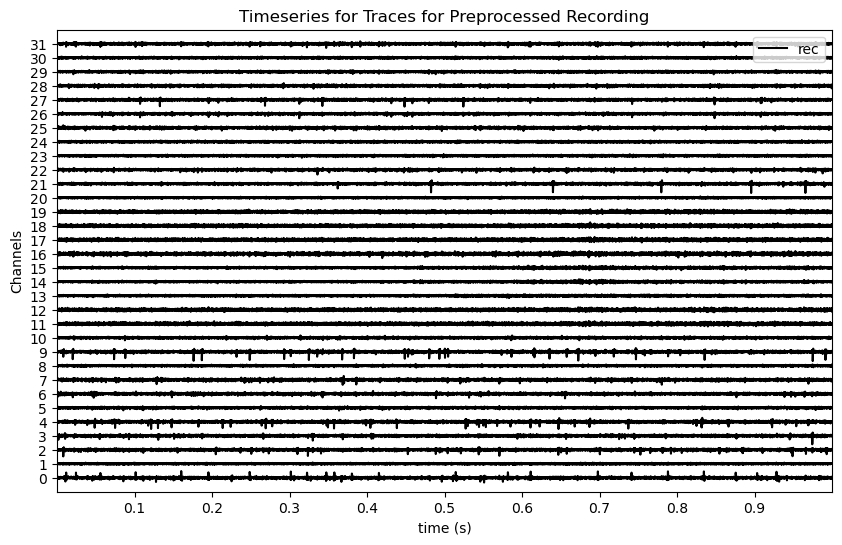

In [19]:
sw.plot_timeseries(recording_preprocessed, show_channel_ids=True)
plt.title("Timeseries for Traces for Preprocessed Recording")
plt.ylabel("Channels")

In [20]:
channel_ids = np.random.choice(recording_preprocessed.channel_ids, size=5, replace=False)

In [21]:
channel_ids = sorted(channel_ids, key=lambda x: float(x))

In [22]:
channel_ids = ["2", "5", "6", "10", "26"]

Text(0, 0.5, 'Channels')

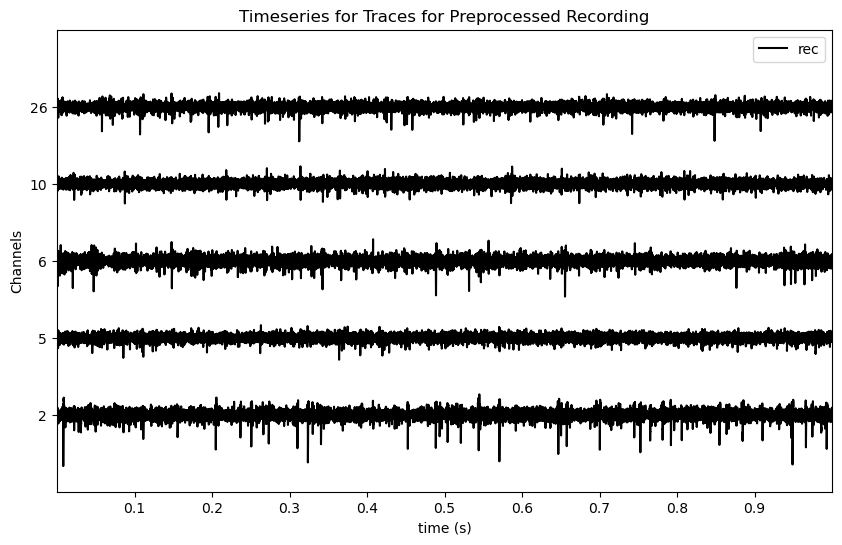

In [23]:

sw.plot_timeseries(recording_preprocessed, channel_ids=channel_ids, show_channel_ids=True)
plt.title("Timeseries for Traces for Preprocessed Recording")
plt.ylabel("Channels")

- Looking over the probe

In [24]:
probe_object = recording_preprocessed.get_probegroup()

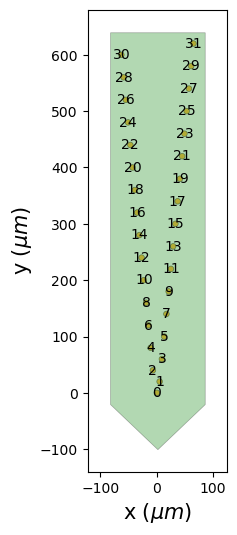

In [25]:
plot_probe_group(probe_object, same_axes=False, with_channel_index=True)
plt.show()

# Part 2: Sorting

Now you are ready to spike sort using the :code:`sorters` module!
Let's first check which sorters are implemented and which are installed



In [26]:
print('Available sorters', ss.available_sorters())

Available sorters ['combinato', 'hdsort', 'herdingspikes', 'ironclust', 'kilosort', 'kilosort2', 'kilosort2_5', 'kilosort3', 'klusta', 'mountainsort4', 'pykilosort', 'spykingcircus', 'spykingcircus2', 'tridesclous', 'tridesclous2', 'waveclus', 'waveclus_snippets', 'yass']


The :code:`ss.installed_sorters()` will list the sorters installed in the machine.
We can see we have mountainsort4 and Tridesclous installed.
Spike sorters come with a set of parameters that users can change.
The available parameters are dictionaries and can be accessed with:



In [27]:
sorter_name = 'mountainsort4'

In [29]:
print(ss.get_default_sorter_params(sorter_name))

{'detect_sign': -1, 'adjacency_radius': -1, 'freq_min': 300, 'freq_max': 6000, 'filter': True, 'whiten': True, 'num_workers': 1, 'clip_size': 50, 'detect_threshold': 3, 'detect_interval': 10, 'tempdir': None}


Let's run a spike sorter and change one of the parameter, say, the detect_threshold:



In [31]:
ss_params = ss.get_default_sorter_params(sorter_name).copy()

- Changing the default parameters for these parameters
    - These are the parameters changed in Maya's video

In [32]:
# To only look for negative peaks
ss_params['detect_sign'] = 0
# So that each channel is sorted independently
ss_params['adjacency_radius'] = 700
# False because we have already filtered the recordings
ss_params['filter'] = False
ss_params['num_workers'] = 16

## Creating a folder for Spike Sorting Output

In [33]:
all_parent_recording_directories = glob.glob("./proc/*")

In [34]:
all_parent_recording_directories

['./proc/6_1_novel']

- If you have more than one recording directory, then you must either:
    - A. Put the index of the file in `all_recording_directories[0]` below. You would replace the `0` with the correct index. (Remember, Python is zero indexed so the first file in the list is 0. Second is 1, and so forth.
    - B. Add a absolute or relative path to `(file_or_folder_or_dict={./path/to/recording_file.rec}`) below. You would replace `{./path/to/recording_file.rec}` with the path of the file for the metadata.

In [35]:
parent_output_directory = all_parent_recording_directories[0]

- Creating a directory within the recording directory for preprocessing and saving the preprocessed recordings into it 

In [36]:
parent_spikesorting_output_directory = os.path.join(parent_output_directory, sorter_name)


In [37]:
parent_spikesorting_output_directory

'./proc/6_1_novel/mountainsort4'

In [38]:
current_date = datetime.today().strftime('%Y_%m_%d')

dated_spikesorting_output_directory = os.path.join(parent_spikesorting_output_directory, current_date)

In [39]:
dated_spikesorting_output_directory

'./proc/6_1_novel/mountainsort4/2023_03_21'

In [40]:
os.makedirs(dated_spikesorting_output_directory, exist_ok=True)

- Sorting usually takes at least a hour. Uncomment the code block below to run it. 

In [41]:
all_sorter_methods = [sorter for sorter in dir(ss) if sorter_name in sorter and "run" in sorter]

In [42]:
all_sorter_methods

['run_mountainsort4']

In [43]:
sorter_method_name = all_sorter_methods[0]

In [44]:
sorter_method_call = getattr(ss, sorter_method_name)

In [45]:
sorter_method_call

<function spikeinterface.sorters.runsorter.run_mountainsort4(*args, **kwargs)>

In [46]:
child_spikesorting_output_directory = os.path.join(dated_spikesorting_output_directory,"ss_output")

In [47]:
if not os.path.exists(child_spikesorting_output_directory):
    start = time.time()
    sorter_method_call(recording=recording_preprocessed,
                                  verbose=True,
                                   output_folder=child_spikesorting_output_directory ,
                                   **ss_params)
    print("Sorting finished in: ", time.time() - start)
else:
    warnings.warn("""Directory already exists for: {}. 
    Either continue on if you are satisfied with the previous run 
    or delete the directory and run this cell again""".format(dated_spikesorting_output_directory))

whitening
Mountainsort4 use the OLD spikeextractors mapped with NewToOldRecording
Using temporary directory None
Using 16 workers.
Using tempdir: /tmp/tmpwc79y8at
Num. workers = 16
Preparing /tmp/tmpwc79y8at/timeseries.hdf5...
Preparing neighborhood sorters (M=32, N=24011275)...
Neighboorhood of channel 31 has 32 channels.
Detecting events on channel 32 (phase1)...
Neighboorhood of channel 25 has 32 channels.
Detecting events on channel 26 (phase1)...
Neighboorhood of channel 20 has 32 channels.
Detecting events on channel 21 (phase1)...
Neighboorhood of channel 6 has 32 channels.
Detecting events on channel 7 (phase1)...
Neighboorhood of channel 1 has 32 channels.
Detecting events on channel 2 (phase1)...
Neighboorhood of channel 15 has 32 channels.
Detecting events on channel 16 (phase1)...
Elapsed time for detect on neighborhood: 0:00:12.676685
Num events detected on channel 32 (phase1): 86809
Computing PCA features for channel 32 (phase1)...
Elapsed time for detect on neighborhood:

Elapsed time for detect on neighborhood: 0:00:10.250382
Num events detected on channel 27 (phase1): 77180
Computing PCA features for channel 27 (phase1)...
Elapsed time for detect on neighborhood: 0:00:10.935039
Num events detected on channel 9 (phase1): 89758
Computing PCA features for channel 9 (phase1)...
Elapsed time for detect on neighborhood: 0:00:10.658714
Num events detected on channel 14 (phase1): 69798
Computing PCA features for channel 14 (phase1)...
Elapsed time for detect on neighborhood: 0:00:11.059737
Num events detected on channel 22 (phase1): 52341
Computing PCA features for channel 22 (phase1)...
Clustering for channel 6 (phase1)...
Clustering for channel 27 (phase1)...
Found 3 clusters for channel 6 (phase1)...
Computing templates for channel 6 (phase1)...
Clustering for channel 14 (phase1)...
Found 8 clusters for channel 27 (phase1)...
Computing templates for channel 27 (phase1)...
Clustering for channel 9 (phase1)...
Found 2 clusters for channel 14 (phase1)...
Comp

Found 2 clusters for channel 21 (phase2)...
Neighboorhood of channel 23 has 32 channels.
Computing PCA features for channel 24 (phase2)...
No duplicate events found for channel 10 in phase2
Clustering for channel 11 (phase2)...
No duplicate events found for channel 26 in phase2
Clustering for channel 27 (phase2)...
Found 3 clusters for channel 11 (phase2)...
Neighboorhood of channel 29 has 32 channels.
Computing PCA features for channel 30 (phase2)...
Found 5 clusters for channel 27 (phase2)...
Neighboorhood of channel 4 has 32 channels.
Computing PCA features for channel 5 (phase2)...
No duplicate events found for channel 27 in phase2
Clustering for channel 28 (phase2)...
No duplicate events found for channel 7 in phase2
Clustering for channel 8 (phase2)...
Found 5 clusters for channel 28 (phase2)...
Found 2 clusters for channel 8 (phase2)...
Neighboorhood of channel 14 has 32 channels.
Computing PCA features for channel 15 (phase2)...
No duplicate events found for channel 29 in phase

In [48]:
spike_sorted_object = ss.read_sorter_folder(child_spikesorting_output_directory)

- Plotting the Rasters

Text(0, 0.5, 'Unit IDs')

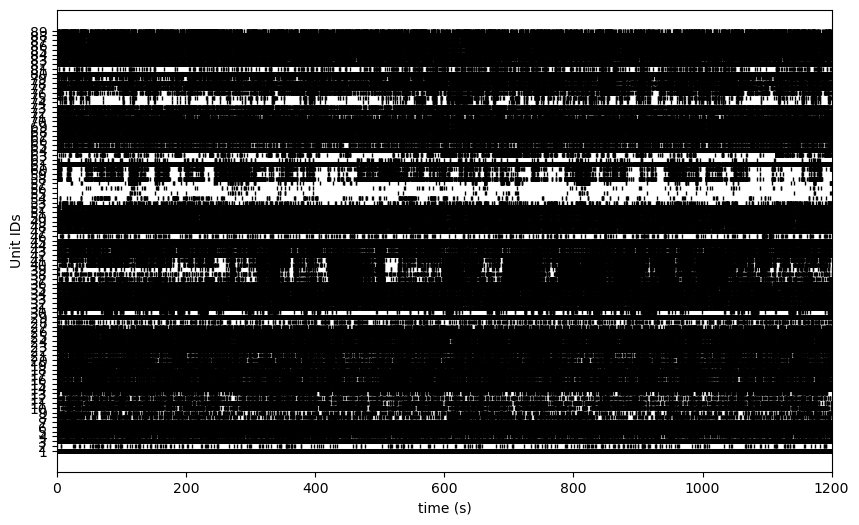

In [49]:
sw.plot_rasters(spike_sorted_object)
plt.ylabel("Unit IDs")